In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Activation, Input, Dropout
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, RandomHeight, RandomWidth
from tensorflow.keras import mixed_precision
import matplotlib.pyplot as plt
import random
import datetime
import os
import zipfile

In [ ]:
# достаем данные из kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
 84% 125M/149M [00:00<00:00, 213MB/s] 
100% 149M/149M [00:00<00:00, 196MB/s]


In [ ]:
# Функция для разархивирования
def unzip_data(filename):
  zip_ref = zipfile.ZipFile(filename, "r")
  zip_ref.extractall()
  zip_ref.close()

In [ ]:
unzip_data('brain-tumor-mri-dataset.zip')

In [ ]:
# делим данные на train и test датасеты

train_dir = "Training"
test_dir = "Testing"

train_data = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                         image_size=(224, 224),
                                                         label_mode='categorical',
                                                         seed=0)
test_data = tf.keras.utils.image_dataset_from_directory(test_dir,
                                                        image_size=(224, 224),
                                                        label_mode='categorical',
                                                        seed=0)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
# смотрим какие классы есть

class_names = train_data.class_names
num_classes = len(class_names)
print("The dataset contains the following {} classes: {}".format(num_classes, class_names))

The dataset contains the following 4 classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


In [ ]:
# смотрим сколько изображений в каждом датасете

def count_files_in_directory(directory_path):
    file_count = 0
    for root, dirs, files in os.walk(directory_path):
        file_count += len(files)
    return file_count

files_in_training_dir = count_files_in_directory("Training")
files_in_testing_dir = count_files_in_directory("Testing")

print(f"Total number of files in training dataset: {files_in_training_dir}")
print(f"Total number of files in testing dataset: {files_in_testing_dir}")

Total number of files in training dataset: 5712
Total number of files in testing dataset: 1311


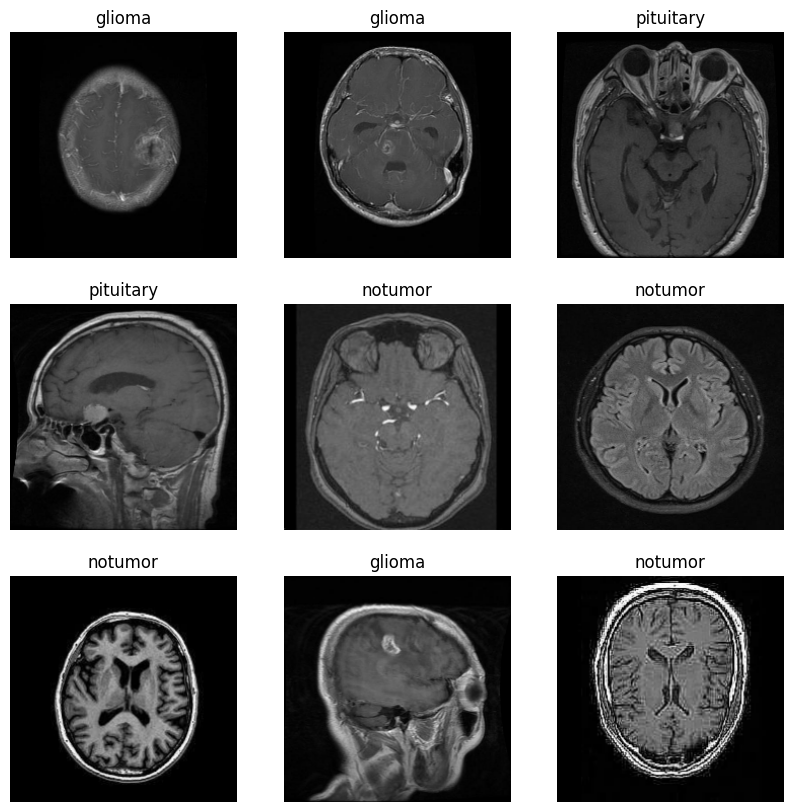

In [ ]:
# Делаем visualization из рандомных изображений из тренировочного датасета

plt.figure(figsize=(10, 10))

random_batch_num = random.randint(1, len(train_data))

for images, labels in train_data.take(random_batch_num):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype('uint8'))
    plt.title(class_names[tf.argmax(labels[i])])
    plt.axis('off')

In [ ]:
# Видоизменяем данные чтобы уменьшить overfitting

data_augmentation = keras.Sequential([
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomWidth(0.2),
    RandomHeight(0.2),
    RandomFlip('horizontal')
])

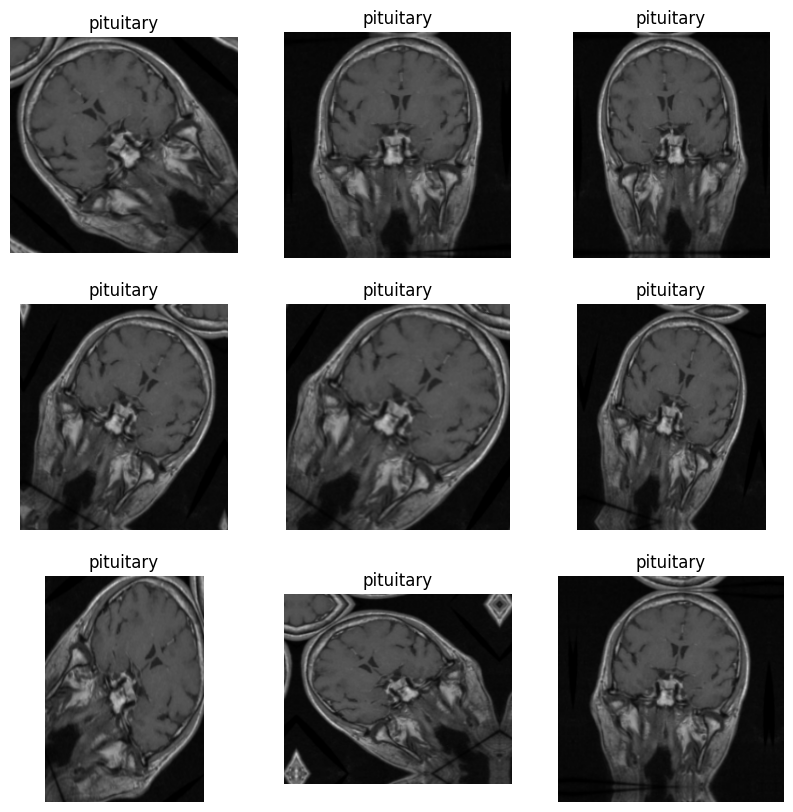

In [ ]:
# Visualization для измененных данных

plt.figure(figsize=(10, 10))
random_batch_num = random.randint(1, len(train_data))
for images, labels in train_data.take(random_batch_num):
  for i in range(9):
    plt.subplot(3, 3, i + 1)
    augmented_images = data_augmentation(images)
    plt.imshow(augmented_images[0].numpy().astype('uint8'))
    plt.title(class_names[tf.argmax(labels[0])])
    plt.axis('off')

In [ ]:
# prefetch
train_data = train_data.prefetch(tf.data.AUTOTUNE)
test_data = test_data.prefetch(tf.data.AUTOTUNE)

In [ ]:
# Функция для создания callback для визуализации в Tensorboard
def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [ ]:
# Используем mixed precision для более быстрых вычислений

mixed_precision.set_global_policy('mixed_float16')
print(mixed_precision.global_policy)

<function global_policy at 0x7fb39453e440>


In [ ]:
# создаем модель на основе EfficientNetV2

base_model = keras.applications.efficientnet_v2.EfficientNetV2B0(include_top=False)
base_model.trainable = False

input_shape = (224, 224, 3)

inputs = Input(shape=input_shape, name='input_layer')
x = data_augmentation(inputs)
x = base_model(x, training=False)
x = GlobalAveragePooling2D(name='global_average_pooling_layer')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2, name='dropout_layer_1')(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2, name='dropout_layer_2')(x)
x = Dense(4)(x)

outputs = Activation('softmax', dtype=tf.float32, name='output_layer')(x)

model = keras.Model(inputs, outputs)


In [ ]:
# Компилируем модель

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                    epochs=10,
                    steps_per_epoch=len(train_data),
                    callbacks=[create_tensorboard_callback(dir_name='brain_tumor_detection', experiment_name='feature_extraction_training')])

Saving TensorBoard log files to: brain_tumor_detection/feature_extraction_training/20230825-123653
Epoch 1/10
179/179 [==============================] - 91s 406ms/step - loss: 0.5054 - accuracy: 0.8104
Epoch 2/10
179/179 [==============================] - 60s 331ms/step - loss: 0.3486 - accuracy: 0.8724
Epoch 3/10
179/179 [==============================] - 51s 280ms/step - loss: 0.3042 - accuracy: 0.8874
Epoch 4/10
179/179 [==============================] - 47s 262ms/step - loss: 0.2821 - accuracy: 0.8955
Epoch 5/10
179/179 [==============================] - 39s 215ms/step - loss: 0.2457 - accuracy: 0.9109
Epoch 6/10
179/179 [==============================] - 38s 210ms/step - loss: 0.2397 - accuracy: 0.9130
Epoch 7/10
179/179 [==============================] - 38s 207ms/step - loss: 0.2302 - accuracy: 0.9140
Epoch 8/10
179/179 [==============================] - 34s 188ms/step - loss: 0.2209 - accuracy: 0.9177
Epoch 9/10
179/179 [==============================] - 31s 174ms/step - loss: 

In [ ]:
# результаты модели на test dataset

model_test_results = model.evaluate(test_data)

41/41 [==============================] - 6s 59ms/step - loss: 0.4226 - accuracy: 0.8612


In [ ]:
# Функция для импорта и изменения изображения для загрузку в модель
def load_and_prep_image(filename, img_shape=224, scale=True):
  img = tf.io.read_file(filename)
  img = tf.image.decode_jpeg(img)
  img = tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.
  else:
    return img

In [ ]:
# Функция для проверки модели на случайном изображении предоставленным пользователем
def pred_and_plot(model, filename, class_names, actual_class):

  img = load_and_prep_image(filename, scale=False)

  pred = model.predict(tf.expand_dims(img, axis=0))

  if len(pred[0]) > 1:
    pred_class = class_names[pred.argmax()]
  else:
    pred_class = class_names[int(tf.round(pred)[0][0])]

  plt.imshow(img)
  plt.title(f"Prediction: {pred_class}, Actual: {actual_class}")
  plt.axis(False);

1/1 [==============================] - 0s 27ms/step
[[9.99881387e-01 1.15298084e-04 2.96499798e-06 3.82146283e-07]]
0


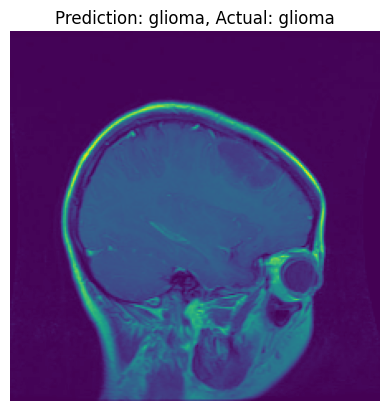

In [ ]:
# тестируем модель на рандомном изображении из тестового датасета
random_class = random.choice(class_names)
random_image = random.choice(os.listdir(os.path.join('Testing', random_class)))
random_image_path = os.path.join('Testing', random_class, random_image)
pred_and_plot(model=model,
              filename=random_image_path,
              class_names=class_names,
              actual_class=random_class)

In [ ]:
# сохраняем модель
model.save('brain_tumor_detection_model.h5')